# Sparse Gaussian Process 

In [1]:
import matplotlib as mpl; mpl.use('pgf')

In [2]:
%matplotlib inline

In [3]:
import numpy as np

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from collections import defaultdict

from matplotlib import animation
from IPython.display import HTML
from etudes.gaussian_processes import gp_sample_custom, dataframe_from_gp_samples

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
golden_ratio = 0.5 * (1 + np.sqrt(5))
golden_size = lambda width: (width, width / golden_ratio)

In [5]:
width = 10

rc = {
    "figure.figsize": golden_size(width),
    "text.usetex": True,
}

sns.set(context="notebook", style="ticks", palette="colorblind", font="serif", rc=rc)

In [6]:
# shortcuts
tfd = tfp.distributions
kernels = tfp.math.psd_kernels

# constants
n_train = 500
observation_noise_variance = 1e-1

n_features = 1 # dimensionality
n_index_points = 256 # nbr of index points

n_samples = 8 # nbr of GP prior samples
jitter = 1e-2
kernel_cls = kernels.ExponentiatedQuadratic

n_inducing_points = 20
n_epochs = 2000
batch_size = 50

seed = 42 # set random seed for reproducibility
random_state = np.random.RandomState(seed)

x_min, x_max = -1.0, 1.0
y_min, y_max = -3.0, 3.0
x_loc = -0.5
# index points
X_q = np.linspace(x_min, x_max, n_index_points).reshape(-1, n_features)

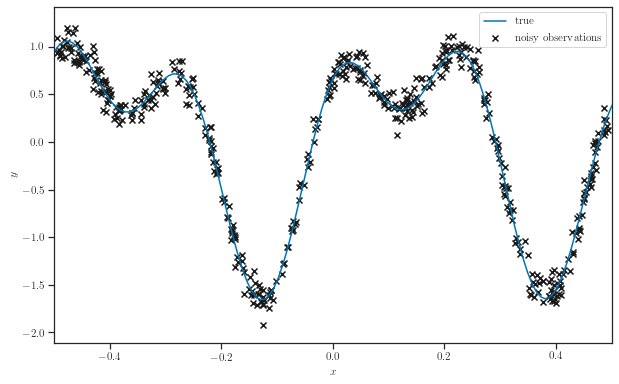

In [7]:
f = lambda x: np.sin(12.0*x) + 0.66*np.cos(25.0*x)

X = x_loc + random_state.rand(n_train, n_features) 
eps = observation_noise_variance * random_state.randn(n_train, n_features)
Y = np.squeeze(f(X) + eps)

fig, ax = plt.subplots()

ax.plot(X_q, f(X_q), label="true")
ax.scatter(X, Y, marker='x', color='k', label="noisy observations")

ax.legend()

ax.set_xlim(x_loc, -x_loc)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.show()

In [66]:
class BatchIdentity(tf.keras.initializers.Identity):

    def __call__(self, shape, dtype=None):

        return super(BatchIdentity, self).__call__(shape[-2:], dtype=None)

In [67]:
shape = (16, 5, 5) 

In [68]:
shape[:-2]

(16,)

In [70]:
tf.keras.backend.repeat(tf.keras.initializers.Identity(gain=1.0)(shape=(5, 5)), n=2)

<tf.Tensor 'Tile_5:0' shape=(5, 2, 5) dtype=float32>

In [102]:
def identity_initializer(shape, dtype=None):

    *batch_shape, num_rows, num_columns = shape

    return tf.eye(num_rows, num_columns, 
                  batch_shape=batch_shape, dtype=dtype)

In [378]:
class VGP(tf.keras.layers.Layer):

    def __init__(self, units, kernel_provider, num_inducing_points=64, mean_fn=None, jitter=1e-6, **kwargs):

        self.units = units # TODO: Maybe generalize to `event_shape`?
        self.num_inducing_points = num_inducing_points
        self.kernel_provider = kernel_provider
        self.mean_fn = mean_fn
        self.jitter = jitter

        super(VGP, self).__init__(**kwargs)

    def build(self, input_shape):

        input_dim = input_shape[-1]

        self.inducing_index_points = self.add_weight(
            name="inducing_index_points",
            shape=(self.units, self.num_inducing_points, input_dim),
            initializer=tf.keras.initializers.RandomUniform(-1, 1), # TODO: initialization
            trainable=True)

        self.variational_inducing_observations_loc = self.add_weight(
            name="variational_inducing_observations_loc",
            shape=(self.units, self.num_inducing_points),
            initializer='zeros', trainable=True)

        self.variational_inducing_observations_scale = self.add_weight(
            name="variational_inducing_observations_scale",
            shape=(self.units, self.num_inducing_points, self.num_inducing_points),
            initializer=identity_initializer, trainable=True)

        super(VGP, self).build(input_shape)

    def call(self, x):

        base = tfd.VariationalGaussianProcess(
            kernel=self.kernel_provider.kernel,
            index_points=x,
            inducing_index_points=self.inducing_index_points,
            variational_inducing_observations_loc=self.variational_inducing_observations_loc,
            variational_inducing_observations_scale=self.variational_inducing_observations_scale,
            mean_fn=self.mean_fn,
            predictive_noise_variance=1e-1,
            jitter=self.jitter
        )

        # sum KL divergence between `units` independent processes
        self.add_loss(tf.reduce_sum(base.surrogate_posterior_kl_divergence_prior()))

        bijector = tfp.bijectors.Transpose(rightmost_transposed_ndims=2)
        qf = tfd.TransformedDistribution(tfd.Independent(base, reinterpreted_batch_ndims=1),
                                         bijector=bijector)

        return qf.sample()

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [379]:
class RBFKernelFn(tf.keras.layers.Layer):

    # TODO: automatic relevance determination
    def __init__(self, **kwargs):
        super(RBFKernelFn, self).__init__(**kwargs)
        dtype = kwargs.get('dtype', None)

        self.ln_amplitude = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype, name='amplitude')

        self.ln_length_scale = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype, name='length_scale')

    def call(self, x):
        # Never called -- this is just a layer so it can hold variables
        # in a way Keras understands.
        return x

    @property
    def kernel(self):
        return kernels.ExponentiatedQuadratic(
            amplitude=tf.exp(self.ln_amplitude),
            length_scale=tf.exp(self.ln_length_scale)
        )

In [380]:
model = tf.keras.models.Sequential([
    VGP(16, kernel_provider=RBFKernelFn(dtype="float64"), jitter=1e-6),
    VGP(32, kernel_provider=RBFKernelFn(dtype="float64"), jitter=1e-6),
    VGP(1, kernel_provider=RBFKernelFn(dtype="float64"), jitter=1e-6)
])
model.losses

[]

In [381]:
model(X_q)

<tf.Tensor 'sequential_15/vgp_128/sequential_15_vgp_128_sequential_15_vgp_128_transposesequential_15_vgp_128_Independentsequential_15_vgp_128_VariationalGaussianProcess/sample/sequential_15_vgp_128_transpose/forward/transpose:0' shape=(256, 1) dtype=float64>

In [382]:
model.losses

[<tf.Tensor 'sequential_15/vgp_126/Sum:0' shape=() dtype=float64>,
 <tf.Tensor 'sequential_15/vgp_127/Sum:0' shape=() dtype=float64>,
 <tf.Tensor 'sequential_15/vgp_128/Sum:0' shape=() dtype=float64>]

In [383]:
kl = tf.reduce_sum(model.losses) / n_train
kl

<tf.Tensor 'truediv_12:0' shape=() dtype=float64>

In [384]:
f1 = VGP(16, kernel_provider=RBFKernelFn(dtype="float64"), jitter=1e-6)(X_q)
f2 = VGP(32, kernel_provider=RBFKernelFn(dtype="float64"), jitter=1e-6)(f1)
f3 = VGP(1, kernel_provider=RBFKernelFn(dtype="float64"), jitter=1e-6)(f2)
f3

<tf.Tensor 'vgp_131/vgp_131_vgp_131_transposevgp_131_Independentvgp_131_VariationalGaussianProcess/sample/vgp_131_transpose/forward/transpose:0' shape=(256, 1) dtype=float64>

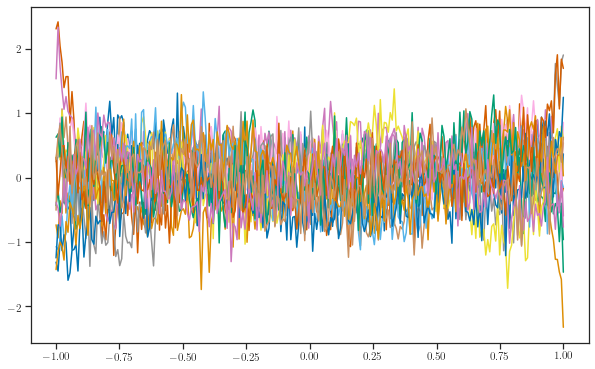

In [387]:
fig, ax = plt.subplots()

with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())

    ax.plot(X_q, f1.eval())

plt.show()

In [229]:
m(X_q)

<tf.Tensor 'vgp_14/vgp_14_vgp_14_transposevgp_14_Independentvgp_14_VariationalGaussianProcess/sample/vgp_14_transpose/forward/transpose:0' shape=(256, 5) dtype=float64>

In [177]:
inducing_index_points_initial = random_state.choice(X.squeeze(), size=(5, n_inducing_points)) \
                                            .reshape(5, n_inducing_points, n_features)
inducing_index_points_initial.shape

(5, 20, 1)

In [212]:
inducing_index_points = tf.Variable(inducing_index_points_initial, 
                                    name='inducing_index_points')

variational_inducing_observations_loc = tf.Variable(np.zeros((5, n_inducing_points)), 
                                                    name='variational_inducing_observations_loc')
variational_inducing_observations_scale = tf.Variable(
    tf.eye(n_inducing_points, batch_shape=(5,), dtype="float64"), name='variational_inducing_observations_scale')

In [213]:
vgp = tfd.VariationalGaussianProcess(
    kernel=kernel,
    index_points=X_q,
    inducing_index_points=inducing_index_points,
    variational_inducing_observations_loc=variational_inducing_observations_loc,
    variational_inducing_observations_scale=variational_inducing_observations_scale,
    observation_noise_variance=0.0,
    jitter=jitter
)

In [214]:
vgp.sample()

<tf.Tensor 'VariationalGaussianProcess_9_1/sample/Reshape:0' shape=(5, 256) dtype=float64>

In [215]:
bijector = tfp.bijectors.Transpose(rightmost_transposed_ndims=2)
bijector

In [216]:
res = tfd.TransformedDistribution(tfd.Independent(vgp, reinterpreted_batch_ndims=1),
                                  bijector=bijector)
res

<tfp.distributions.TransformedDistribution 'transpose_5IndependentVariationalGaussianProcess_9' batch_shape=[] event_shape=[256, 5] dtype=float64>

In [217]:
res.sample()

<tf.Tensor 'transpose_5IndependentVariationalGaussianProcess_9_1/sample/transpose_5/forward/transpose:0' shape=(256, 5) dtype=float64>

In [154]:
variational_inducing_observations_scale

<tf.Variable 'variational_inducing_observations_scale_2:0' shape=(5, 20, 20) dtype=float32_ref>

In [137]:
?np.identity

In [8]:
# amplitude = tf.exp(tf.Variable(np.float64(0)), name='amplitude')
# length_scale = tf.exp(tf.Variable(np.float64(-1)), name='length_scale')
# observation_noise_variance = tf.exp(tf.Variable(np.float64(-5)), name='observation_noise_variance')
# kernel = kernel_cls(amplitude=amplitude, length_scale=length_scale)
# gp = tfd.GaussianProcess(
#     kernel=kernel,
#     index_points=X,
#     observation_noise_variance=observation_noise_variance
# )

In [9]:
# nll = - gp.log_prob(Y)
# nll

In [10]:
# optimizer = tf.train.AdamOptimizer(learning_rate=.05, beta1=.5, beta2=.99)
# optimize = optimizer.minimize(nll)

In [11]:
# history = defaultdict(list)

# with tf.Session() as sess:

#     sess.run(tf.global_variables_initializer())

#     for i in range(500):
#         (_, nll_value, amplitude_value, length_scale_value, 
#          observation_noise_variance_value) = sess.run([optimize, nll, amplitude, length_scale, observation_noise_variance])
#         history["nll"].append(nll_value)
#         history["amplitude"].append(amplitude_value)
#         history["length_scale"].append(length_scale_value)
#         history["observation_noise_variance"].append(observation_noise_variance_value)

In [12]:
# fig, ax = plt.subplots()

# sns.lineplot(x='amplitude', y='length_scale', 
#              sort=False, data=pd.DataFrame(history), alpha=0.8, ax=ax)

# ax.set_xlabel(r"amplitude $\sigma$")
# ax.set_ylabel(r"lengthscale $\ell$")

# plt.show()

In [13]:
# kernel_history = kernel_cls(amplitude=history.get("amplitude"), length_scale=history.get("length_scale"))
# gprm_history = tfd.GaussianProcessRegressionModel(
#     kernel=kernel_history, index_points=X_q, observation_index_points=X, observations=Y,
#     observation_noise_variance=history.get("observation_noise_variance"), jitter=jitter
# )
# gprm_mean = gprm_history.mean()
# gprm_stddev = gprm_history.stddev()

In [14]:
# with tf.Session() as sess:
#     gprm_mean_value, gprm_stddev_value = sess.run([gprm_mean, gprm_stddev])

In [15]:
# fig, ax = plt.subplots()

# ax.plot(X_q, gprm_mean_value[0])
# ax.fill_between(np.squeeze(X_q), 
#                 gprm_mean_value[0] - 2*gprm_stddev_value[0], 
#                 gprm_mean_value[0] + 2*gprm_stddev_value[0], alpha=0.1)

# ax.scatter(X, Y, marker='x', color='k', label="noisy observations")

# ax.set_xlabel('$x$')
# ax.set_ylabel('$y$')
# ax.set_ylim(y_min, y_max)

# plt.show()

In [16]:
# fig, ax = plt.subplots()

# ax.plot(X_q, gprm_mean_value[-1])
# ax.fill_between(np.squeeze(X_q), 
#                 gprm_mean_value[-1] - 2*gprm_stddev_value[-1], 
#                 gprm_mean_value[-1] + 2*gprm_stddev_value[-1], alpha=0.1)

# ax.scatter(X, Y, marker='x', color='k', label="noisy observations")

# ax.set_xlabel('$x$')
# ax.set_ylabel('$y$')
# ax.set_ylim(y_min, y_max)

# plt.show()

In [32]:
amplitude = tf.exp(tf.Variable(np.float64(0)), name='amplitude')
length_scale = tf.exp(tf.Variable(np.float64(-1)), name='length_scale')
observation_noise_variance = tf.exp(tf.Variable(np.float64(-5)), name='observation_noise_variance')
kernel = kernel_cls(amplitude=amplitude, length_scale=length_scale)

In [149]:
inducing_index_points_initial = random_state.choice(X.squeeze(), size=(5, n_inducing_points)) \
                                            .reshape(5, n_inducing_points, n_features)
inducing_index_points_initial.shape

(5, 20, 1)

In [148]:
.shape

(5, 20, 1)

In [19]:
# bijector = tfp.bijectors.Chain([tfp.bijectors.CholeskyOuterProduct(), 
#                                 ])
# bijector

In [20]:
n_inducing_points = 20

In [21]:
inducing_index_points = tf.Variable(inducing_index_points_initial, 
                                    name='inducing_index_points')

# variational_inducing_observations_loc = tf.Variable(np.zeros(n_inducing_points), 
#                                                     name='variational_inducing_observations_loc')
# variational_inducing_observations_scale = tf.Variable(
#     np.eye(n_inducing_points), name='variational_inducing_observations_scale')

# variational_inducing_observations_scale = tfp.util.TransformedVariable(
#     np.eye(n_inducing_points), tfp.bijectors.FillTriangular(), name='variational_inducing_observations_scale'
# )

# variational_inducing_observations_scale_flat = tf.Variable(
#     random_state.rand(n_inducing_points * (n_inducing_points + 1) // 2),
#     name='variational_inducing_observations_scale_flat')
# variational_inducing_observations_scale = tfp.math.fill_triangular(variational_inducing_observations_scale_flat)

In [23]:
dataset = tf.data.Dataset.from_tensor_slices((X, Y)) \
                         .shuffle(buffer_size=500) \
                         .batch(batch_size, drop_remainder=True)
iterator = tf.data.make_initializable_iterator(dataset)
X_batch, Y_batch = iterator.get_next()
X_batch, Y_batch

(<tf.Tensor 'IteratorGetNext:0' shape=(50, 1) dtype=float64>,
 <tf.Tensor 'IteratorGetNext:1' shape=(50,) dtype=float64>)

In [24]:
[variational_inducing_observations_loc, 
 variational_inducing_observations_scale] = tfd.VariationalGaussianProcess.optimal_variational_posterior(
    kernel=kernel,
    inducing_index_points=inducing_index_points,
    observation_index_points=X,
    observations=Y,
    observation_noise_variance=observation_noise_variance
)

In [26]:
vgp = tfd.VariationalGaussianProcess(
    kernel=kernel,
    index_points=X_batch,
    inducing_index_points=inducing_index_points,
    variational_inducing_observations_loc=variational_inducing_observations_loc,
    variational_inducing_observations_scale=variational_inducing_observations_scale,
    observation_noise_variance=observation_noise_variance,
    jitter=jitter
)

In [29]:
vgp

<tfp.distributions.VariationalGaussianProcess 'VariationalGaussianProcess_1' batch_shape=[] event_shape=[50] dtype=float64>

In [30]:
tfd.Independent(vgp, reinterpreted_batch_ndims=1)

ValueError: reinterpreted_batch_ndims(1) cannot exceed distribution.batch_ndims(0)

In [ ]:

bij = transpose_lib.Transpose(rightmost_transposed_ndims=2)
d = transformed_distribution_lib.TransformedDistribution(ind, bijector=bij)

In [27]:
vgp.sample(index_points=X_batch)

<tf.Tensor 'VariationalGaussianProcess_1_1/sample/Reshape:0' shape=(50,) dtype=float64>

In [25]:
nelbo = vgp.variational_loss(
    observations=Y_batch,
    observation_index_points=X_batch,
    kl_weight=batch_size/n_train
)

In [26]:
optimizer = tf.train.AdamOptimizer()
optimize = optimizer.minimize(nelbo)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [27]:
steps_per_epoch = n_train // batch_size
steps_per_epoch

10

In [28]:
n_epochs = 100

In [36]:
history = defaultdict(list)

with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())

    for i in range(n_epochs):

        sess.run(iterator.initializer)
        
        for j in range(steps_per_epoch):

#             sess.run(optimize)
            (_, nelbo_value, 
             amplitude_value, 
             length_scale_value,
             observation_noise_variance_value,
             inducing_index_points_value,
             variational_inducing_observations_loc_value,
             variational_inducing_observations_scale_value) = sess.run([optimize, 
                                                                        nelbo, 
                                                                        amplitude, 
                                                                        length_scale, 
                                                                        observation_noise_variance,
                                                                        inducing_index_points,
                                                                        variational_inducing_observations_loc, 
                                                                        variational_inducing_observations_scale])

        history["nelbo"].append(nelbo_value)
        history["amplitude"].append(amplitude_value)
        history["length_scale"].append(length_scale_value)
        history["observation_noise_variance"].append(observation_noise_variance_value)
        history["inducing_index_points"].append(inducing_index_points_value)
        history["variational_inducing_observations_loc"].append(variational_inducing_observations_loc_value)
        history["variational_inducing_observations_scale"].append(variational_inducing_observations_scale_value)

In [37]:
inducing_index_points_history = np.stack(history["inducing_index_points"])
inducing_index_points_history.shape

(100, 20, 1)

In [38]:
segments_min_history = np.dstack(np.broadcast_arrays(inducing_index_points_history, y_min))
segments_max_history = np.dstack([inducing_index_points_history, 
                                  history["variational_inducing_observations_loc"]])

In [39]:
segments_history = np.stack([segments_max_history, segments_min_history], axis=-2)
segments_history.shape

(100, 20, 2, 2)

In [40]:
kernel_history = kernel_cls(amplitude=history.get("amplitude"), length_scale=history.get("length_scale"))

vgp_history = tfd.VariationalGaussianProcess(
    kernel=kernel_history,
    index_points=X_q,
    inducing_index_points=np.stack(history.get("inducing_index_points")),
    variational_inducing_observations_loc=np.stack(history.get("variational_inducing_observations_loc")),
    variational_inducing_observations_scale=np.stack(history.get("variational_inducing_observations_scale")),
    observation_noise_variance=history.get("observation_noise_variance")
)
vgp_mean = vgp_history.mean()
vgp_stddev = vgp_history.stddev()

In [ ]:
with tf.Session() as sess:
    vgp_mean_value, vgp_stddev_value = sess.run([vgp_mean[::10], vgp_stddev[::10]])

In [ ]:
fig, ax = plt.subplots()

ax.plot(X_q, gprm_mean_value[-1])
ax.fill_between(np.squeeze(X_q), 
                gprm_mean_value[-1] - 2*gprm_stddev_value[-1], 
                gprm_mean_value[-1] + 2*gprm_stddev_value[-1], alpha=0.1)

ax.plot(X_q, vgp_mean_value[-1])
ax.fill_between(np.squeeze(X_q), 
                vgp_mean_value[-1] - 2*vgp_stddev_value[-1], 
                vgp_mean_value[-1] + 2*vgp_stddev_value[-1], alpha=0.1)

ax.scatter(X, Y, marker='x', color='k', label="noisy observations")

ax.vlines(history["inducing_index_points"][-1], ymin=y_min, 
          ymax=history["variational_inducing_observations_loc"][-1],
          color='k', linewidth=1.0, alpha=0.4)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_ylim(y_min, y_max)

plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, gridspec_kw=dict(hspace=0.1))

ax1.scatter(X, Y, marker='x', color='k')

ax1.plot(X_q, gprm_mean_value[-1])
ax1.fill_between(np.squeeze(X_q), 
                 gprm_mean_value[-1] - 2*gprm_stddev_value[-1], 
                 gprm_mean_value[-1] + 2*gprm_stddev_value[-1], alpha=0.1)

line_mean, = ax1.plot(X_q, vgp_mean_value[-1], color="tab:orange")
line_stddev_lower, = ax1.plot(X_q, vgp_mean_value[-1] - 2*vgp_stddev_value[-1], 
                              color="tab:orange", alpha=0.4)
line_stddev_upper, = ax1.plot(X_q, vgp_mean_value[-1] + 2*vgp_stddev_value[-1],
                              color="tab:orange", alpha=0.4)

vlines_inducing_index_points = ax1.vlines(inducing_index_points_history[-1].squeeze(), 
                                          ymax=history["variational_inducing_observations_loc"][-1],
                                          ymin=y_min, linewidth=1.0, alpha=0.4)

ax1.set_ylabel(r'$y$')
ax1.set_ylim(y_min, y_max)

lines_inducing_index_points = ax2.plot(inducing_index_points_history.squeeze(), range(n_epochs),
                                       color='k', linewidth=1.0, alpha=0.4)

ax2.set_xlabel(r"$x$")
ax2.set_ylabel("epoch")

plt.show()

In [ ]:
def animate(i):

    line_mean.set_data(X_q, vgp_mean_value[i])
    line_stddev_lower.set_data(X_q, vgp_mean_value[i] - 2*vgp_stddev_value[i])
    line_stddev_upper.set_data(X_q, vgp_mean_value[i] + 2*vgp_stddev_value[i])

    vlines_inducing_index_points.set_segments(segments_history[i])

    for j, line in enumerate(lines_inducing_index_points):
        line.set_data(inducing_index_points_history[:i, j], range(i))

    ax2.relim()
    ax2.autoscale_view(scalex=False)

    return line_mean, line_stddev_lower, line_stddev_upper

In [ ]:
anim = animation.FuncAnimation(fig, animate, frames=n_epochs,
                               interval=60, repeat_delay=5, blit=True)

In [ ]:
# HTML(anim.to_html5_video())